In [49]:
import os
import pandas as pd 
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

os.environ['WANDB_API_KEY'] = # TODO: you wandb api key

In [45]:
def get_runs(filters, proj='struct_mlp', tune_on='test', avg_seeds=True):
    api = wandb.Api()
    runs = api.runs(proj, filters=filters, order='-created_at')
    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })


    runs_df = runs_df[runs_df['summary'].apply(lambda x: x != {})]
    keys = ['width', 'depth', 'struct', 'lr', 'seed', 'use_wrong_mult']
    for key in keys:
        if key == 'struct':
            # If 'struct' is None, use the value from 'cola_strategy'
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else x.get('cola_strategy', None))
        elif key == 'layers':
            # If 'layers' is None, default to 'all_but_last'
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else 'all_but_last')
        elif key == 'lr':
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else 5e-5)
        else:
            # For other keys, just extract the value if it exists
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x else -1)
    runs_df['first_layer_flops'] = runs_df['width'] * (32 * 32 * 3)
    # rank_frac == 1 if struct is not low_rank
    runs_df.loc[~runs_df['struct'].isin(['low_rank', 'low_rank_and_kron', 'sum']), 'rank_frac'] = 1
        
    for key in ['test_acc', 'train_acc_avg', 'epoch', 'dh_avg_2']:
        runs_df[key] = runs_df['summary'].apply(lambda x: x[key] if key in x else -1)
    runs_df['test_error'] = 100 - runs_df['test_acc']
    runs_df['train_error_avg'] = 100 - runs_df['train_acc_avg']

    # delete name summary and config
    runs_df = runs_df.drop(columns=['summary', 'config', 'name'])
    
    # Everything else being equal, only keep the max test_acc run
    if tune_on is not None:
        # remove lr
        keys = [k for k in keys if k != 'lr']
        if 'loss' in tune_on:
            idx = runs_df.groupby(keys)[tune_on].idxmin()
        else:
            idx = runs_df.groupby(keys)[tune_on].idxmax()
        runs_df = runs_df.loc[idx]
    # average over seeds
    if avg_seeds:
        keys = [k for k in keys if k != 'seed']
        runs_df = runs_df.groupby(keys).mean().reset_index()
    return runs_df

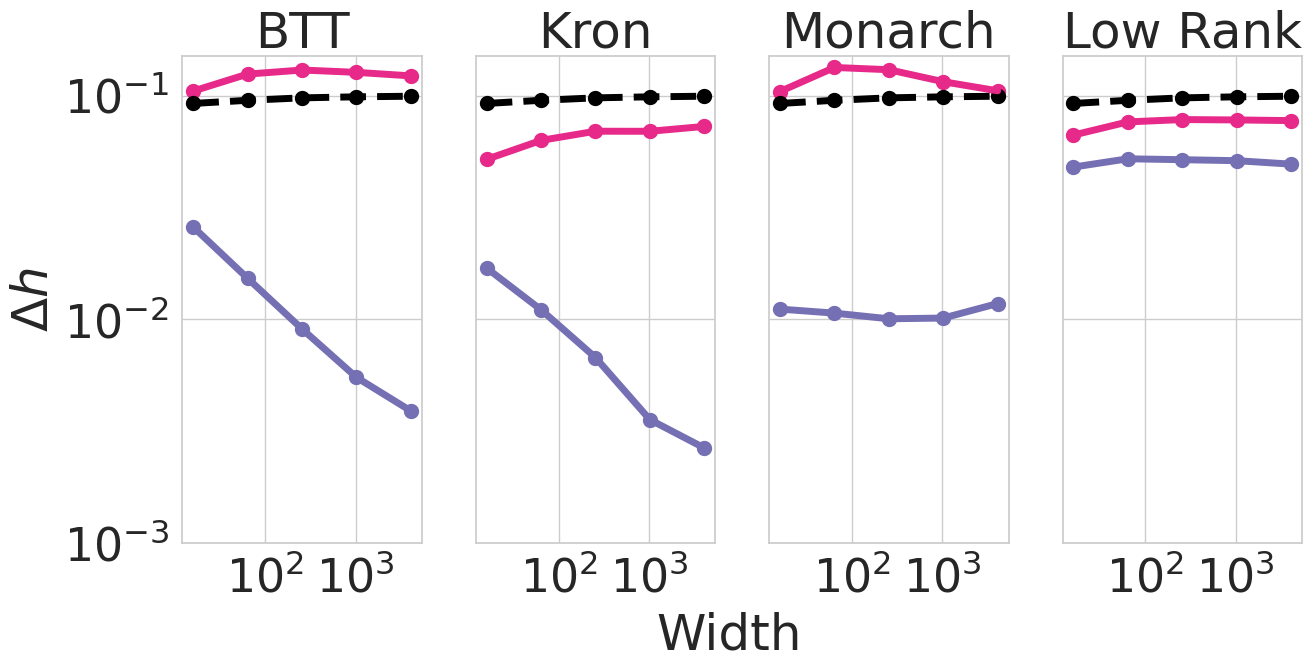

/tmp/ipykernel_2404022/2651455196.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


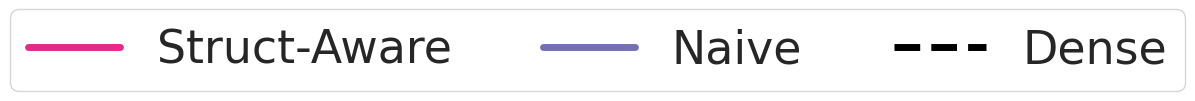

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

filters = {
    "state": "finished",
    "config.dataset": {"$eq": 'cifar10'},
    "config.model": {"$eq": 'MLP'},
    "config.struct": {"$in": ['btt', 'dense', 'kron', 'low_rank', 'monarch']},
    "config.epochs": {"$eq": 500},
}
# assuming the experiments were logged to wandb under the project name 'check_dh'
df = get_runs(filters, proj='check_dh', tune_on=None, avg_seeds=True)

sns.set(style="whitegrid", font_scale=3.0, rc={"lines.linewidth": 5.0})
pal = sns.color_palette("Dark2", as_cmap=True)
pal = [pal(3), pal(2)]


case_map = {'btt': "BTT", 'kron': "Kron", 'low_rank': "Low Rank", 'dense': "Dense", 'monarch': 'Monarch'}
color_map = {"BTT": pal[0], "Dense": pal[1], "Kron": pal[0], "Low Rank": pal[0], 'Monarch': pal[0]}
key = "use_wrong_mult"
cases, naive = {}, {}
for struct in list(df['struct'].unique()):
    mask = df['struct'] == struct
    dff = df[mask]
    h_ours = dff[~dff[key]]["width"].values, dff[~dff[key]]["dh_avg_2"].values
    cases[case_map[struct]] = h_ours
    if struct != "dense":
        h_naive = dff[dff[key]]["width"].values, dff[dff[key]]["dh_avg_2"].values
    else:
        h_naive = h_ours
    naive[case_map[struct]] = h_naive

figsize = (14, 7)
dpi = 100

fig, axs = plt.subplots(nrows=1, ncols=4, sharex="all", sharey="all", figsize=figsize, dpi=dpi)
labels = ["BTT", "Kron", "Monarch", "Low Rank"]

for idx, struct in enumerate(labels):
    x, hx = cases[struct]
    label = struct
    axs[idx].set_title(f"{struct}")
    axs[idx].scatter(x, hx, color=pal[0], lw=5)
    axs[idx].plot(x, hx, label="Struct-Aware", linestyle="solid", color=pal[0], lw=5)
    x, hx = naive[struct]
    axs[idx].scatter(x, hx, color=pal[1], lw=5)
    axs[idx].plot(x, hx, linestyle="solid", color=pal[1], label="Naive", lw=5)
    label = "Dense"
    x, hx = cases[label]
    axs[idx].scatter(x, hx, color='black', lw=5)
    axs[idx].plot(x, hx, linestyle="dashed", color='black', label="Dense", lw=5)
    handles, labels = axs[idx].get_legend_handles_labels()
axs[0].set_ylabel(r'$\Delta h$')

plt.ylim([0.001, 0.15])
plt.xscale('log')
plt.yscale('log')
fig.text(0.5, 0.01, "Width")
plt.tight_layout()
plt.savefig('width_vs_dh.pdf')
plt.show()

legend_fig = plt.figure(figsize=(14, 1))
legend_ax = legend_fig.add_subplot(111)
legend_ax.axis('off')
legend_ax.legend(handles=handles, labels=labels, loc='center', ncol=len(labels))
plt.tight_layout()
plt.savefig('width_vs_dh_legend.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_2404022/4241431327.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ours_df['struct'] = ours_df['struct'].apply(lambda x: x.capitalize())
/tmp/ipykernel_2404022/4241431327.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  naive_df['struct'] = naive_df['struct'].apply(lambda x: x.capitalize())
/tmp/ipykernel_2404022/4241431327.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r"$10

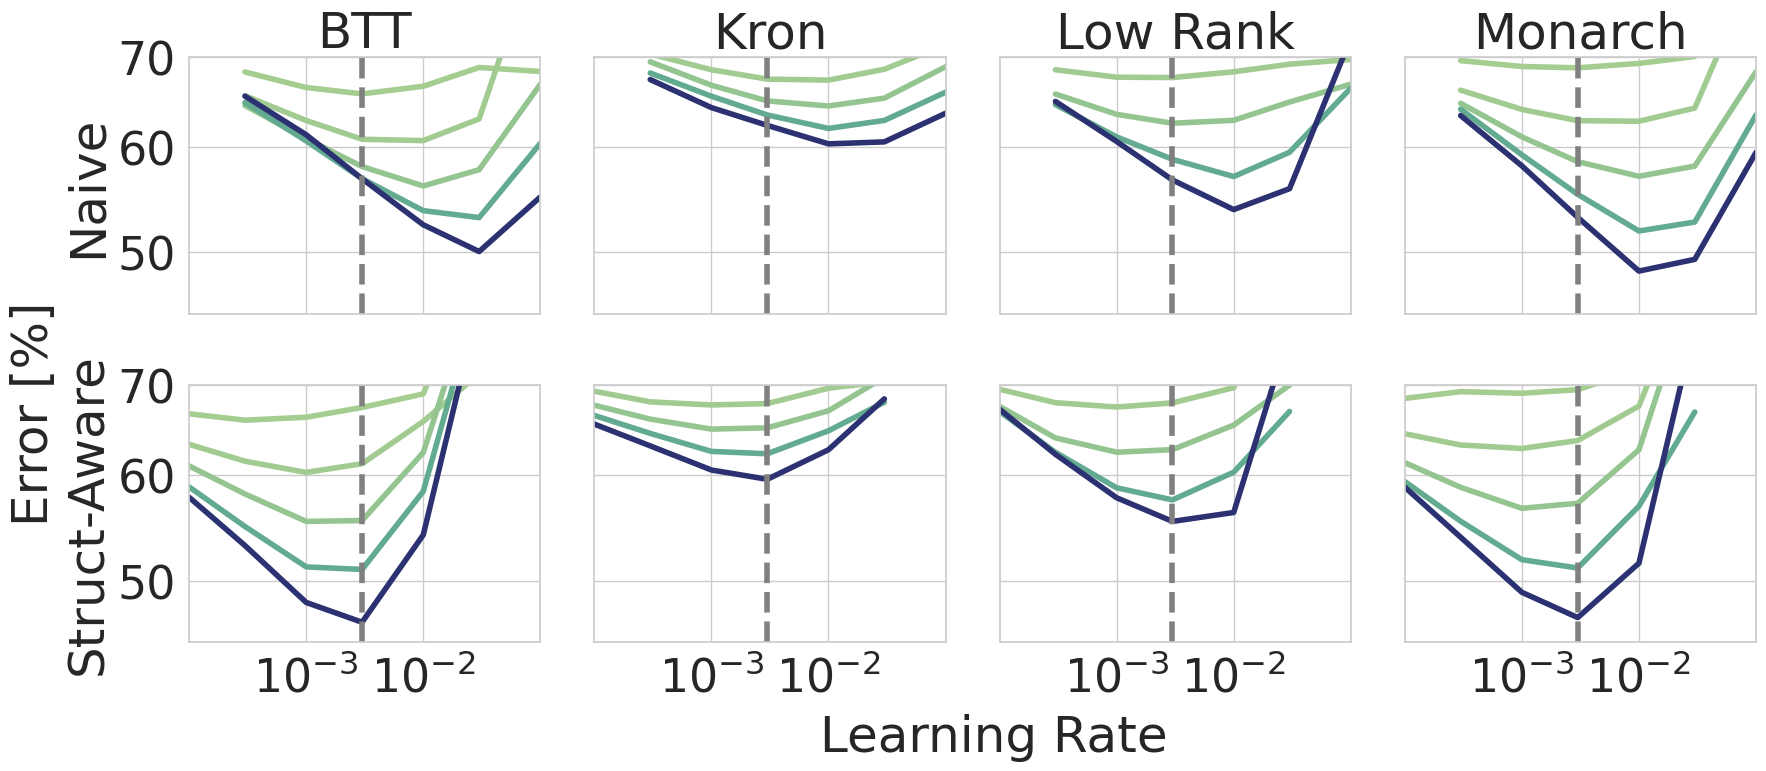

/tmp/ipykernel_2404022/4241431327.py:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


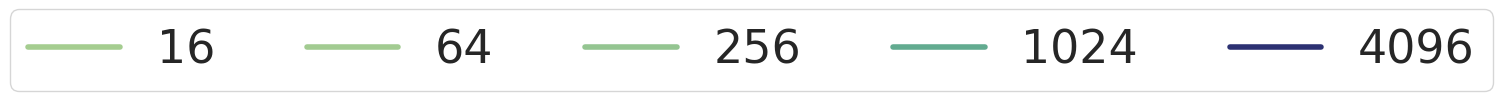

In [48]:
filters = {
    "state": "finished",
    "config.dataset": {"$eq": 'cifar10'},
    "config.struct": {"$in": ['btt', 'dense', 'kron', 'low_rank', 'monarch']},
    "config.model": {"$eq": 'MLP'},
    "config.epochs": {"$eq": 100},
}

# assuming the experiments were logged to wandb under the project name 'lr_landscape'
runs = get_runs(filters, proj='lr_landscape', tune_on=None)
runs = runs[runs['struct'] != 'dense']
ours_df = runs[~runs['use_wrong_mult']]
naive_df = runs[runs['use_wrong_mult']]

ours_df['struct'] = ours_df['struct'].apply(lambda x: x.capitalize())
naive_df['struct'] = naive_df['struct'].apply(lambda x: x.capitalize())
num_struct = len(ours_df['struct'].unique())
fig, axes = plt.subplots(2, num_struct, sharex="all", sharey="all", figsize=(num_struct * 4.5, 8), dpi=100)
axes = axes.reshape(2, -1)
ylims = [45,  70]
xlims = [1e-4, 1e-1]
xticks = [1e-3, 1e-2]
yticks = [50, 60, 70]
struct_map = {"Kron": "Kron", "Low_rank": "Low Rank", "Monarch": "Monarch", "Btt": "BTT"}
sns.set(style="whitegrid", font_scale=3, rc={"lines.linewidth": 4.0})
pal = sns.color_palette("crest", as_cmap=True)
for i, struct in enumerate(ours_df['struct'].unique()):
    ax = axes[0, i]
    sns.lineplot(data=naive_df[naive_df['struct'] == struct], x='lr', y='train_error_avg', hue='width', ax=ax, legend=False, palette=pal)

    ax.set_title(f'{struct_map[struct]}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i == 0:
        ax.set_ylabel('Naive')
    else:
        ax.set_ylabel('')
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.axvline(x=3e-3, color='gray', linestyle='--')

    ax = axes[1, i]
    sns.lineplot(data=ours_df[ours_df['struct'] == struct], x='lr', y='train_error_avg', hue='width', ax=ax, palette=pal)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i == 0:
        ax.set_ylabel('Struct-Aware')
    else:
        ax.set_ylabel('')
    ax.axvline(x=3e-3, color='gray', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_xticklabels([r"$10^{-3}$", r"$10^{-2}$"])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(["50", "60", "70"])
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

fig.text(0.45, 0.005, "Learning Rate")
fig.text(0.00, 0.3, "Error [%]", rotation=90)
plt.tight_layout()
plt.savefig('lr_landscape.pdf')
plt.show()

legend_fig = plt.figure(figsize=(8, 1))
legend_ax = legend_fig.add_subplot(111)
legend_ax.axis('off')
legend_ax.legend(handles=handles, labels=labels, loc='center', ncol=len(labels))
plt.tight_layout()
plt.savefig('lr_landscape_legend.pdf', bbox_inches='tight')